In [1]:
import sys
sys.path.append(r'/home/xian/extra_pkgs/hextof-processor')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpes import fprocessing as fp, visualization as vis
import scipy.io as sio
import animo as a
%matplotlib inline
import tifffile as ti

import mpld3 # interactive plots
mpld3.enable_notebook()
mpld3.disable_notebook()

from importlib import reload
import processor.DldFlashDataframeCreator as DldFlashProcessor
import processor.utils as utils

In [10]:
processor = DldFlashProcessor.DldFlashProcessor()
processor.runNumber = 22124

ToFfrom = 660
ToFto = 690
ToFstep = 30*processor.TOF_STEP_TO_NS

# delay parameters
delayFrom = -514.1
delayTo = -509.5
delayStep = 0.02

dldFrom = 0
dldTo = 2800
dldStep = 35

try:
    processor.readDataframes()
except:
    processor.readData()
    processor.storeDataframes()
# BAM correction
processor.postProcess()

# Filter by macrobunch
processor.addFilter('dldMicrobunchId', lb=100, ub=400)

processor.resetBins()
pX = processor.addBinning('dldPosX',dldFrom,dldTo,dldStep)
pY = processor.addBinning('dldPosY',dldFrom,dldTo,dldStep)
ToF = processor.addBinning('dldTime', ToFfrom,ToFto,ToFstep)
delay = processor.addBinning('pumpProbeTime', delayFrom,delayTo,delayStep)
res = processor.computeBinnedData()

100%|██████████| 2/2 [03:57<00:00, 118.58s/it]


In [13]:
res.shape

(80, 80, 146, 231)

In [24]:
from h5py import File
def hdf5Writer(binaxes, binned=None, cutaxis=0, save_addr=r'./', typ='float64'):
    
    hdf = File(save_addr, 'w')
    nbinaxes = len(binaxes)
    
    try:
        # Save the binned data
        # Save 1-3D data as single datasets
        if nbinaxes < 4:
            hdf.create_dataset('binned/V', data=binned.astype(typ))
        # Save 4D data as a list of separated 3D datasets
        elif nbinaxes == 4:
            nddata = np.rollaxis(binned, cutaxis)
            n = nddata.shape[0]
            for i in range(n):
                hdf.create_dataset('binned/V'+str(i), data=nddata[i,...].astype(typ))
        else:
            raise NotImplementedError('High dimensional data format undefined!')

        # Save the axes in the same group
        for k, v in binaxes.items():
            hdf.create_dataset('axes/'+k, data=v.astype(typ))
    
    except:
        pass
    
    finally:
        
        hdf.close()

In [7]:
hdf5Writer(binaxes={'ToF':ToF, 'pX':pX, 'pY':pY, 'tPP':delay}, binned=res, \
           save_addr='./Run=22125_4axis_80x80x146x230.h5', typ='float32')

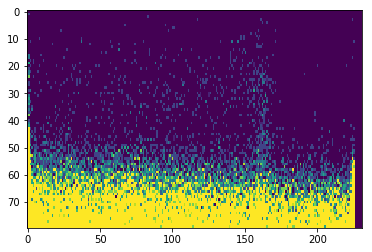

In [14]:
plt.imshow(res[:,:,:80,:].sum(axis=(0,1)), aspect='auto', vmax=10)

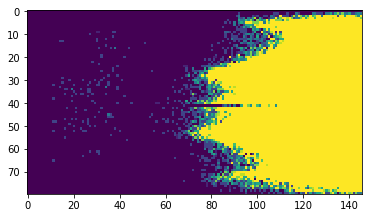

In [31]:
plt.imshow(res[45:,:,:,:150].sum(axis=(0,3)), vmax=10)

### Pump power vs microbunch ID

In [50]:
processor = DldFlashProcessor.DldFlashProcessor()
processor.runNumber = 22130

try:
    processor.readDataframes()
except:
    processor.readData()
    processor.storeDataframes()
# BAM correction
processor.postProcess()

processor.resetBins()
mid = processor.addBinning('dldMicrobunchId', 0, 500, 1)
opticalDiode = processor.addBinning('opticalDiode', 15000, 125000, 500)
#delay = processor.addBinning('pumpProbeTime', delayFrom,delayTo,delayStep)
respd = processor.computeBinnedData()

100%|██████████| 2/2 [00:13<00:00,  6.84s/it]


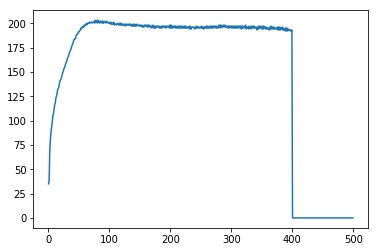

In [44]:
plt.plot(mid, np.argmax(respd, axis=1))

In [51]:
res22130 = respd.copy()

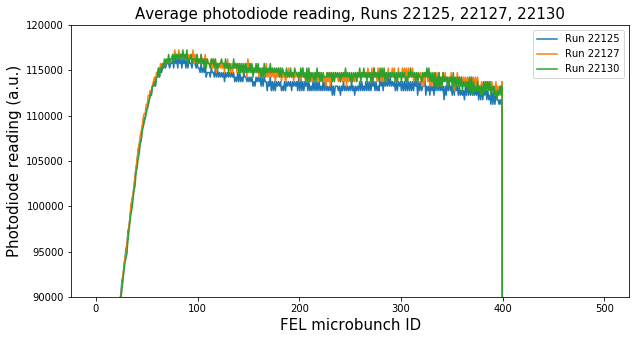

In [54]:
plt.figure(figsize=(10,5))
plt.plot(mid, opticalDiode[np.argmax(res22125, axis=1)], label='Run 22125')
plt.plot(mid, opticalDiode[np.argmax(res22127, axis=1)], label='Run 22127')
plt.plot(mid, opticalDiode[np.argmax(res22130, axis=1)], label='Run 22130')
plt.legend()
plt.title('Average photodiode reading, Runs 22125, 22127, 22130', fontsize=15)
plt.xlabel('FEL microbunch ID', fontsize=15)
plt.ylabel('Photodiode reading (a.u.)', fontsize=15)
plt.savefig('Photodiode_Run22125-22130.png', bbox_inches='tight', dpi=300)

In [55]:
binres = np.concatenate((res22125, res22127, res22130), axis=0)

In [56]:
hdf5Writer(binaxes={'OD':opticalDiode, 'uID':mid, 'scans':[22124, 22126, 22128]}, \
           binned=binres, save_addr='./Run=22125_22127_22130_Diode.h5', typ='float32')

### Obtain pump-off states

In [49]:
processor = DldFlashProcessor.DldFlashProcessor()
processor.runNumber = 22130

ToFfrom = 660
ToFto = 760
ToFstep = 80*processor.TOF_STEP_TO_NS

# delay parameters
delayFrom = -514.1
delayTo = -508.8
delayStep = 0.1

dldFrom = 0
dldTo = 2800
dldStep = 25

try:
    processor.readDataframes()
except:
    processor.readData()
    processor.storeDataframes()
# BAM correction
processor.postProcess()
processor.shiftQuadrants()

# Filter by macrobunch
processor.addFilter('dldMicrobunchId', lb=100, ub=400)

processor.resetBins()
pX = processor.addBinning('dldPosX',dldFrom,dldTo,dldStep)
pY = processor.addBinning('dldPosY',dldFrom,dldTo,dldStep)
ToF = processor.addBinning('dldTime', ToFfrom,ToFto,ToFstep)
delay = processor.addBinning('pumpProbeTime', delayFrom,delayTo,delayStep)
res = processor.computeBinnedData()

100%|██████████| 2/2 [01:23<00:00, 41.66s/it]


In [50]:
res.shape

(112, 112, 183, 54)

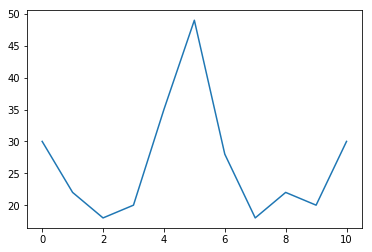

In [55]:
plt.plot(res[:,:,10:25,34:45].sum(axis=(0,1,2)))

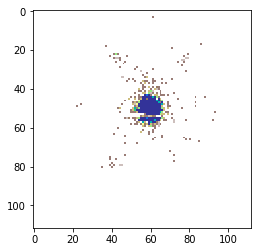

In [56]:
pret0 = res[:,:,:,34:45]
plt.imshow(pret0[:,:,10:30,:].sum(axis=(2,3)), cmap='terrain_r', vmax=10)

In [57]:
hdf5Writer(binaxes={'ToF':ToF, 'pX':pX, 'pY':pY, 'tPP':delay}, binned=res, \
           save_addr='./Run=22130_4axis_112x112x183x54.h5', typ='float32')

In [58]:
ti.imsave('./WSe2_FLASH_Beamtime_22130_pret0.tiff', data=pret0.sum(axis=3).astype('float32'))

### Combine pre-t0 data

In [59]:
pre125 = ti.imread('./WSe2_FLASH_Beamtime_22125_pret0.tiff')
pre127 = ti.imread('./WSe2_FLASH_Beamtime_22127_pret0.tiff')
pre130 = ti.imread('./WSe2_FLASH_Beamtime_22130_pret0.tiff')

In [60]:
pret0 = pre125 + pre127 + pre130
ti.imsave('./WSe2_FLASH_Beamtime_22125-22130_pret0.tiff', data=pret0.astype('float32'))